***Подключене библиотек***

In [43]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.tree import plot_tree

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

sns.set_palette('husl')
%matplotlib inline

***Описание дата-сета***

Датасет heart.csv со следующими полями (наличие сердечных заболеваний)

https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset/data

*   age : Возраст
*   sex : Пол (1 = мужской; 0 = женский)
*   cp : боль в груди (0 - типичная, 1 - асимптотическая, 2 - неангинальная, 3 - нетипичная)
*   trestbps : кровяное давление в состоянии покоя
*   chol : холестерин сыворотки в мг/дл
*   fbs : уровень сахара в крови натощак > 120 мг/дл (1 = верно; 0 = неверно)
*   restecg : результаты электрокардиографии в состоянии покоя
*   thalach : максимальная частота сердечных сокращений
*   exang : стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)
*   oldpeak : депрессия ST, вызванная нагрузкой по сравнению с отдыхом
*   slope : Наклон пикового сегмента ST при нагрузке
*   ca : количество крупных сосудов, окрашенных флюороскопически (0–3)
*   thal : (3 = нормально; 6 = фиксированный дефект; 7 = обратимый дефект)
*   target : АГД - Диагностика заболеваний сердца (1 = да; 0 = нет)

***1. Загрузка данных***

In [44]:
heart = pd.read_csv('heart.csv', delimiter=',')
heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


***2. Определение данных для нормализации***

In [45]:
def utils_recognize_type(dtf, col, max_cat=20):
    '''
      Определяет, является ли столбец числовым или категориальным.
      :параметр
          :param dtf: dataframe - входные данные
          :param col:str - имя столбца для анализа
          :param max_cat: num — максимальное количество уникальных значений для распознавания столбца как категориального
      :возвращает
          "cat", если столбец является категориальным или "num" в противном случае
    '''

    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

In [46]:
'''
формируем словарь dic_cols.
Ключи - название фич
Значение - категориальный (cat) или числовой (num)
'''
dic_cols = {col:utils_recognize_type(heart, col, max_cat=20) for col in heart.columns}
dic_cols

{'age': 'num',
 'sex': 'cat',
 'cp': 'cat',
 'trestbps': 'num',
 'chol': 'num',
 'fbs': 'cat',
 'restecg': 'cat',
 'thalach': 'num',
 'exang': 'cat',
 'oldpeak': 'num',
 'slope': 'cat',
 'ca': 'cat',
 'thal': 'cat',
 'target': 'cat'}

Нормализовывать будем столбцы age, trestbps, chol, thalach, oldpeak

**3. Разделение набора данных**

Y  - целевая переменная, которую предсказываем. Мы ищем зависимость этой переменной от соответствующих фич.  В нашем случае это столбец class.

В X складываем весь набор данных без целевой переменной.

In [47]:
y = heart['target']
X = heart.drop(['target'], axis=1)

print(f'X shape: {X.shape} | y shape: {y.shape} ')

X shape: (1025, 13) | y shape: (1025,) 


Разделяем наш набор данных на обучающий (train) и тестовый (test) с помощью train_test_split(), мы берем 80% данных для обучения нашей модели и 20% оставляем в качестве проверочного набора данных, параметр stratify гарантирует, что пропорции классов в обучающей и тестовой выборках будут такими же, как в исходном наборе данных.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10, stratify=y)

In [49]:
print("X_train shape:", X_train.shape, "| X_test shape:", X_test.shape)
print("y_train mean:", round(np.mean(y_train), 2), "| y_test mean:", round(np.mean(y_test), 2))
print(X_train.shape[1], "features:", X.columns.to_list())

X_train shape: (820, 13) | X_test shape: (205, 13)
y_train mean: 0.51 | y_test mean: 0.51
13 features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


**4. Стандартизация**

In [50]:
# Стандартизация только для количественных данных
num_cols = [col for col in dic_cols if dic_cols[col] == "num"]
num_cols

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [51]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Применяем стандартизацию только к количественным признакам
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

**5. Модели регрессии**

Функция расчета необходимых метрик

In [52]:
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

    # Calculating Adjusted R-squared
    r2 = model.score(X_test, y_test)
    # Number of observations is the shape along axis 0
    n = X_test.shape[0]
    # Number of features (predictors, p) is the shape along axis 1
    p = X_test.shape[1]
    # Adjusted R-squared formula
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    print(f'RMSE: {round(RMSE,4)}\n R2: {round(R2,4)}\n Adjusted R2: {round(adjusted_r2, 4)}\n Cross Validated R2: {round(cv_score.mean(),4)}')
    return R2, adjusted_r2, CV_R2, RMSE

**5.1. Линейная регрессия**

In [53]:
modelLR = LinearRegression()
modelLR.fit(X_train_scaled, y_train)
y_pr_LR = modelLR.predict(X_test_scaled)

_ = Reg_Models_Evaluation_Metrics(modelLR, X_train_scaled, y_train, X_test_scaled, y_test, y_pr_LR)

RMSE: 0.3497
 R2: 0.5106
 Adjusted R2: 0.4773
 Cross Validated R2: 0.4906


**5.2. Полиномиальная регрессия**

In [54]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

modelPR = LinearRegression()
modelPR.fit(X_train_poly, y_train)
y_pr_PR = modelPR.predict(X_test_poly)

_ = Reg_Models_Evaluation_Metrics(modelPR, X_train_poly, y_train, X_test_poly, y_test, y_pr_PR)

RMSE: 0.2341
 R2: 0.7806
 Adjusted R2: 1.1261
 Cross Validated R2: 0.538


**5.3. Регрессия дерева принятия решений**

In [55]:
modelDT = DecisionTreeRegressor()
modelDT.fit(X_train_scaled, y_train)
y_dt_pred = modelDT.predict(X_test_scaled)

_ = Reg_Models_Evaluation_Metrics(modelDT, X_train_scaled, y_train, X_test_scaled, y_test, y_dt_pred)

RMSE: 0.1397
 R2: 0.9219
 Adjusted R2: 0.9166
 Cross Validated R2: 0.9354


**5.4. Регрессия случайного леса**

In [56]:
modelRF = RandomForestRegressor(n_estimators=100)
modelRF.fit(X_train_scaled, y_train)
y_rf_pred = modelRF.predict(X_test_scaled)

_ = Reg_Models_Evaluation_Metrics(modelRF, X_train_scaled, y_train, X_test_scaled, y_test, y_rf_pred)

RMSE: 0.1145
 R2: 0.9475
 Adjusted R2: 0.9439
 Cross Validated R2: 0.938


**5.6. Регрессия опорных векторов (SVR)**

In [57]:
modelSVR = SVR(kernel='linear')
modelSVR.fit(X_train_scaled, y_train)
y_rf_pred = modelSVR.predict(X_test_scaled)

_ = Reg_Models_Evaluation_Metrics(modelSVR, X_train_scaled, y_train, X_test_scaled, y_test, y_rf_pred)

RMSE: 0.3571
 R2: 0.4897
 Adjusted R2: 0.4549
 Cross Validated R2: 0.4519


**5.7. Регрессия ElasticNet**

In [58]:
modelEN = ElasticNet(alpha=0.1, l1_ratio=0.8)
modelEN.fit(X_train_scaled, y_train)
y_en_pred = modelEN.predict(X_test_scaled)

_ = Reg_Models_Evaluation_Metrics(modelEN, X_train_scaled, y_train, X_test_scaled, y_test, y_en_pred)

RMSE: 0.4085
 R2: 0.332
 Adjusted R2: 0.2865
 Cross Validated R2: 0.3388


**Лучшие модели**

Регрессия дерева принятия решений : R2 = 0.9219

In [59]:
# Глубина дерева
depth = modelDT.get_depth()
print(f"Глубина дерева: {depth}")

# Количество листовых узлов
n_leaves = modelDT.get_n_leaves()
print(f"Количество листовых узлов: {n_leaves}")

# Количество узлов
n_nodes = modelDT.tree_.node_count
print(f"Количество узлов: {n_nodes}")


Глубина дерева: 8
Количество листовых узлов: 51
Количество узлов: 101


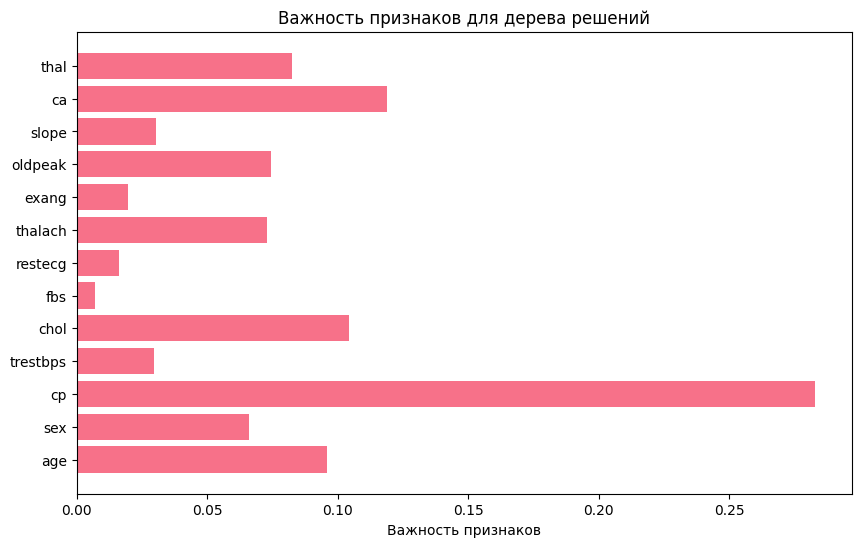

In [60]:
# Важность признаков
importances = modelDT.feature_importances_

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), X_train.columns)  # Если X_train - DataFrame
plt.xlabel("Важность признаков")
plt.title("Важность признаков для дерева решений")
plt.show()

In [61]:
plt.figure(figsize=(20,15), dpi=600)
plot_tree(modelDT, feature_names=X.columns, filled=True)

[Text(0.4324596774193548, 0.9444444444444444, 'cp <= 0.5\nsquared_error = 0.25\nsamples = 820\nvalue = 0.513'),
 Text(0.2056451612903226, 0.8333333333333334, 'ca <= 0.5\nsquared_error = 0.185\nsamples = 397\nvalue = 0.244'),
 Text(0.3190524193548387, 0.8888888888888888, 'True  '),
 Text(0.12096774193548387, 0.7222222222222222, 'thal <= 2.5\nsquared_error = 0.249\nsamples = 176\nvalue = 0.472'),
 Text(0.04838709677419355, 0.6111111111111112, 'thalach <= -1.244\nsquared_error = 0.2\nsamples = 98\nvalue = 0.724'),
 Text(0.03225806451612903, 0.5, 'squared_error = 0.0\nsamples = 7\nvalue = 0.0'),
 Text(0.06451612903225806, 0.5, 'exang <= 0.5\nsquared_error = 0.171\nsamples = 91\nvalue = 0.78'),
 Text(0.03225806451612903, 0.3888888888888889, 'chol <= 1.36\nsquared_error = 0.051\nsamples = 56\nvalue = 0.946'),
 Text(0.016129032258064516, 0.2777777777777778, 'squared_error = 0.0\nsamples = 50\nvalue = 1.0'),
 Text(0.04838709677419355, 0.2777777777777778, 'slope <= 1.5\nsquared_error = 0.25\nsa

Регрессия случайного леса: R2 = 0.9473

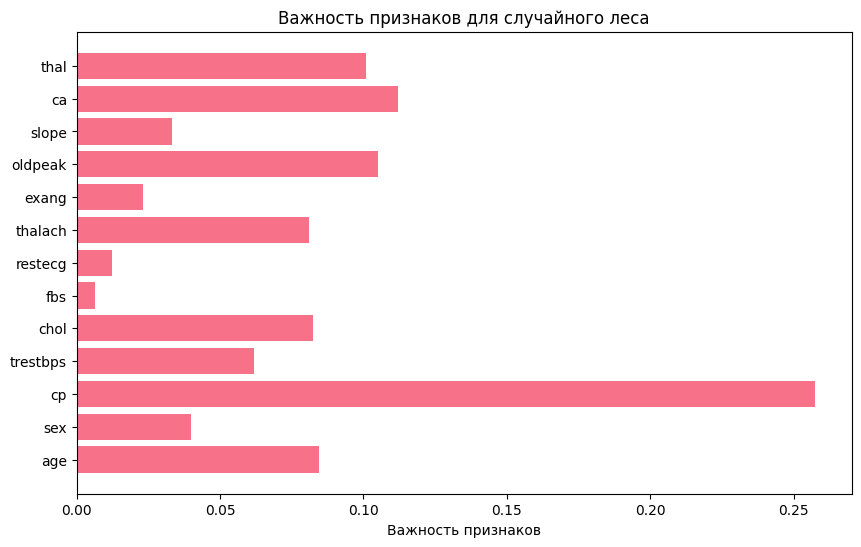

In [62]:
# Важность признаков
importances = modelRF.feature_importances_

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), X_train.columns)
plt.xlabel("Важность признаков")
plt.title("Важность признаков для случайного леса")
plt.show()

**Визуализация на параметре age (количественный)**

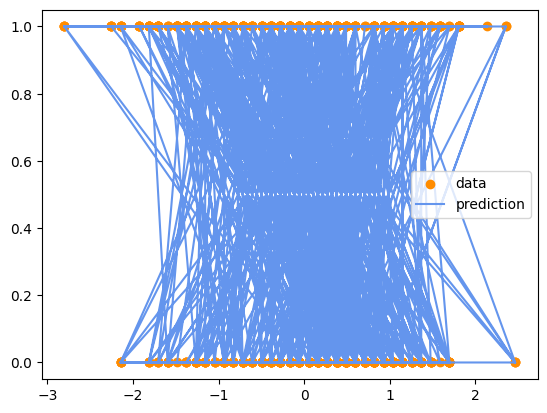

In [63]:
plt.scatter(X_train_scaled["age"], y_train, color='darkorange',
            label='data')
plt.plot(X_train_scaled["age"], modelDT.predict(X_train_scaled), color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

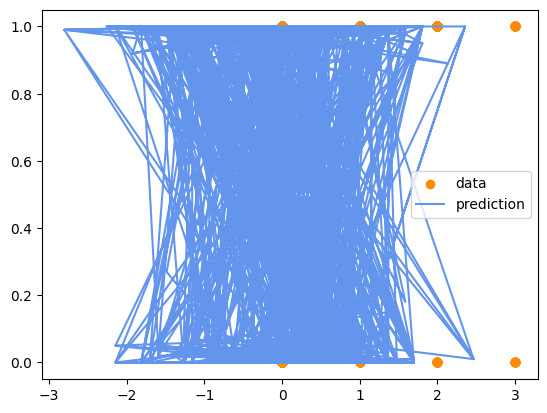

In [64]:
plt.scatter(X_train_scaled["cp"], y_train, color='darkorange',
            label='data')
plt.plot(X_train_scaled["age"], modelRF.predict(X_train_scaled), color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()